# this is the manuscript for ploting Figure 2 in the lake ice manuscript

In [1]:
import numpy as np # version '1.20.0'
import xarray as xr # version '0.16.2'
from tqdm import tqdm # version '4.43.0'
import matplotlib.pyplot as plt # version '3.3.2'
import matplotlib as mpl # version '3.3.2'
import cmocean # version '2.0'
import cartopy.crs as ccrs # version '0.18.0'
import cartopy.feature as cf # version '0.18.0'
import glob
import dask.array as da # version '2021.1.1'
import time
from numpy import nan
import seaborn as sns # version '0.11.0'
import pandas as pd # version 1.2.1'
import matplotlib.path as mpath

In [3]:
# setup the dask parallel computing
from dask.distributed import Client
client = Client(scheduler_file= '.../scheduler.json') # the path to the scheduler file
client

Client Scheduler: tcp://203.247.189.224:39429 Dashboard: http://203.247.189.224:8787/status,Cluster Workers: 16 Cores: 576 Memory: 320.00 GB


# 1. define functions

## 1.1 define functions to read in nc files across all the ensemble members
The variables stored in the directories of individual ensemble members ,we use this function to read the data of all the ensemble members into one xarray dataset

In [5]:
def def_process_coords(exceptcv=[]):
    def process_coords(ds, except_coord_vars=exceptcv):
        coord_vars = []
        for v in np.array(ds.coords):
            if not v in except_coord_vars:
                coord_vars += [v]
        for v in np.array(ds.data_vars):
            if not v in except_coord_vars:
                coord_vars += [v]
        return ds.drop(coord_vars)
    return process_coords
#-----------------------------------------------------------------------------------------------------
def read_in(var, exceptcv, domain='lnd/', freq='day_1/', stream='h6', chunks=dict(time=365), ens_s=-20, ens_e=-10):
    ens_dir = "path for the home directory of the whole CESM-LE data"
    histens_names = [member.split('archive/')[1][:-1]
                     for member in sorted(glob.glob(ens_dir + "b.e21.BHIST*LE2*[!old][!tmp]/"))][10:]
    projens_names = [member.split('archive/')[1][:-1] for member in sorted(
        glob.glob(ens_dir + "b.e21.BSSP370*.f09_g17*[!old][!tmp]/"))][10:]
    hist_ncfiles = []
    proj_ncfiles = []
    for i in np.arange(ens_s, ens_e):
        hist_fnames = sorted(glob.glob(
            ens_dir + histens_names[i] + "/" + domain + "proc/tseries/" + freq + "*" + stream + var + "*"))
        proj_fnames = sorted(glob.glob(
            ens_dir + projens_names[i] + "/" + domain + "proc/tseries/" + freq + "*" + stream + var + "*"))
        hist_ncfiles.append(hist_fnames)
        proj_ncfiles.append(proj_fnames)
    ens_numbers = [members.split('LE2-')[1]
                   for members in histens_names][ens_s:ens_e]
    hist_ds = xr.open_mfdataset(hist_ncfiles,
                                chunks=chunks,
                                preprocess=def_process_coords(exceptcv),
                                combine='nested',
                                concat_dim=[[*ens_numbers], 'time'],
                                parallel=True)
    proj_ds = xr.open_mfdataset(proj_ncfiles,
                                chunks=chunks,
                                preprocess=def_process_coords(exceptcv),
                                combine='nested',
                                concat_dim=[[*ens_numbers], 'time'],
                                parallel=True)
    if freq == 'day_1/':
        hist_ds = hist_ds.isel(time=np.arange(1, hist_ds.time.shape[0]))
        proj_ds = proj_ds.isel(time=np.arange(1, proj_ds.time.shape[0]))
        hist_ds['time'] = hist_ds.time.get_index('time').shift(-1, 'D')
        proj_ds['time'] = proj_ds.time.get_index('time').shift(-1, 'D')
    if freq == 'month_1/':
        hist_ds['time'] = hist_ds.time.get_index('time').shift(-1, 'M')
        proj_ds['time'] = proj_ds.time.get_index('time').shift(-1, 'M')
    ens_ds = xr.concat((hist_ds, proj_ds), 'time')
    ens_ds = ens_ds.rename({'concat_dim': 'ensemble'})
    return ens_ds


## 1.2 define functions calculate linear trend along time dimension 

In [6]:
# this function refers code from https://gist.github.com/luke-gregor/4bb5c483b2d111e52413b260311fbe43
def xarray_trend(xarr,taxis = 'time', units = '\u2103'):    
    from scipy import stats
    # getting shapes
    
    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]
    
    x = np.arange(xarr[taxis][0],xarr[taxis][-1:] + 1,1)[:,None]
    y = xarr.to_masked_array().reshape(n, -1)
    
    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly
    
    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)
    
    
    # preparing outputs
    out = xarr[:2].mean(taxis)
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
    xarr_slope.name += '_slope'
    xarr_slope.attrs['units'] = units + ' / ' + taxis
    xarr_slope.values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name += '_Pvalue'
    xarr_p.attrs['info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])
    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p

    return xarr_out

## 1.3 build a mask array transfer lonxlat grid into a sequential order 
please note, not all the grids has lake simulaiton, in the grids without lake simulation, the values are NaN, to reduce the running memory cost, we transfer lonxlat grid into a sequential order and delete those grids without lake simulation, thus improving the computing efficiency

In [9]:
mask_ds = xr.open_mfdataset('.../b.e21.BHISTcmip6.f09_g17.LE2-1231.001.clm2.h2.EFLX_LH_TOT.185001-185912.nc', # randomly read in one clm5 output file to extract information for the coordinates
                        combine = 'by_coords',
                          parallel=True)

In [10]:
ixy = mask_ds.land1d_ixy - 1
ixy['landunit'] = mask_ds.land1d_ityplunit
lake_ixy = ixy.sel(landunit = 5).astype(int).compute()
jxy = mask_ds.land1d_jxy - 1
jxy['landunit'] = mask_ds.land1d_ityplunit
lake_jxy = jxy.sel(landunit = 5).astype(int).compute()
## change lake_ixy lake_jxy coordinate to make it consistent with computation afterwards
lake_ixy['landunit'] = np.arange(lake_ixy.shape[0])
lake_jxy['landunit'] = np.arange(lake_jxy.shape[0])

In [11]:
landunit_idx = mask_ds.landunit
landunit_idx['landunit'] = mask_ds.land1d_ityplunit
lake_idx = landunit_idx.sel(landunit = 5).values

calculate the lake area and make mask to remove antarctic and greenland

In [12]:
pct_lake_ds = xr.open_dataset('.../surfdata_map/surfdata_0.9x1.25_78pfts_CMIP6_simyr1850_c170824.nc')# the surface input data for CLM5
pct_lake = pct_lake_ds.PCT_LAKE / 100
pct_lake = pct_lake.rename({'lsmlat':'lat','lsmlon':'lon'})
pct_lake = pct_lake.where(pct_lake > 0)
pct_lake['lat'] = mask_ds.lat
pct_lake['lon'] = mask_ds.lon

landfrac  = pct_lake_ds.LANDFRAC_PFT
landfrac  = landfrac.rename({'lsmlat':'lat','lsmlon':'lon'})
landfrac['lat'] = mask_ds.lat
landfrac['lon'] = mask_ds.lon

cell_area = pct_lake_ds.AREA
cell_area = cell_area.rename({'lsmlat':'lat','lsmlon':'lon'})
cell_area['lat'] = mask_ds.lat
cell_area['lon'] = mask_ds.lon

In [13]:
## setup mask to remove ocean and ice sheet area
glacier_region = pct_lake_ds.GLACIER_REGION
glacier_region = glacier_region.rename(dict(lsmlat = 'lat', lsmlon = 'lon'))
glacier_region['lat'] = mask_ds.lat
glacier_region['lon'] = mask_ds.lon

landfrac = landfrac.where(glacier_region == 0,0)

pct_lake = pct_lake.where(landfrac > 0)

lake_area = cell_area * landfrac * pct_lake

In [14]:
lake_mask = (pct_lake_ds.PCT_LAKE > 0)
lake_mask = lake_mask.rename({'lsmlat':'lat','lsmlon':'lon'})
lake_mask['lat'] = mask_ds.lat
lake_mask['lon'] = mask_ds.lon
## remove lakes in antarctic and greenland
lake_mask = lake_mask.where(landfrac > 0,False)

In [15]:
lake_area_lunit = lake_area[lake_jxy, lake_ixy]

In [16]:
lake_mask_lunit = lake_mask[lake_jxy, lake_ixy]

In [17]:
lake_ixy = lake_ixy.sel(landunit = lake_mask_lunit)
lake_jxy = lake_jxy.sel(landunit = lake_mask_lunit)
lake_idx = lake_idx[lake_mask_lunit]
lake_area_lunit = lake_area_lunit.sel(landunit = lake_mask_lunit)

In [18]:
lake_area_lunit = lake_area[lake_jxy, lake_ixy]
lake_mask_lunit = lake_mask[lake_jxy, lake_ixy]

# 2. read in data and calculation for the trend

## 2.1 the CESM2-LENS ice phenology data

In [19]:
# these are data that have been calculated in calculation script
iceduration_day = xr.open_mfdataset('/proj/lhuang/LENS/ICEDURATION_mod.nc',
                                   chunks={'ensemble':1},
                                   parallel=True).iceduration
icemax_day = xr.open_mfdataset('/proj/lhuang/LENS/ICEMAX_mod.nc',
                                 chunks={'ensemble':1},
                                 parallel=True).icemax

In [20]:
# convert the lonxlat grid into sequential order along landunit dimension
iceduration_day_lunit = iceduration_day[:,:,lake_jxy,lake_ixy].compute()
iceduration_day_lunit_ano     = iceduration_day_lunit - iceduration_day_lunit.sel(year = slice(2000,2020)).mean('year')
ice_thick_max_lunit = icemax_day[:,:,lake_jxy,lake_ixy].compute()
ice_thick_max_lunit_ano = ice_thick_max_lunit - ice_thick_max_lunit.sel(year = slice(2000,2020)).mean('year')

## 2.2 surface air temperature change and calculate the annual mean

In [21]:
variables = ['TREFHT']
exceptcv = ['time', 'lat', 'lon', *variables]
tsa_ds = read_in(var = '.TREFHT.', 
                 exceptcv= exceptcv, 
                 domain = 'atm/', 
                 freq = 'day_1/', 
                 stream = 'h1', 
                 ens_s = 0, 
                 ens_e = 90, 
                 chunks = dict(time = 40) )
## assign lnd coordinates to atm coordinates, so that prect can use lnd mask
## In reality, lnd coordinates is very close to atm coordinates, so use lnd mask on atm data is fine
tsa_ds['lat'] = mask_ds.lat
tsa_ds['lon'] = mask_ds.lon

/home/huanglei/usr/anaconda3/envs/pyncl/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [100]:
tsa_day = tsa_ds.TREFHT
tsa_day['time'] = tsa_day.time.get_index('time').shift(-232,"D")
tsa_day  = tsa_day.sel(time = slice('1850-01-01','2099-12-31'))

In [101]:
tsa_ann= tsa_day.groupby('time.year').mean('time')
tsa_ann = tsa_ann.transpose('ensemble','year', 'lat','lon')

In [102]:
tsa_ann_lunit_C = (tsa_ann[:5,:,lake_jxy,lake_ixy] - 273.15).compute()
for i in tqdm(np.arange(1,18), desc = '1st loop'):
    tsa_ann_lunit_C = xr.concat((tsa_ann_lunit_C, (tsa_ann[i*5:(i+1)*5,:,lake_jxy,lake_ixy] - 273.15).compute() ), dim = 'ensemble' )

In [27]:
## calculate the anomaly of temperature 
tsa_ann_lunit_ano = tsa_ann_lunit_C - tsa_ann_lunit_C.sel(year = slice(2000,2020)).mean('year') 

## 2.3 observational data

### 2.3.1 observational surface air temperature

In [28]:
cru_tsa = xr.open_dataset('/proj/lhuang/LENS/OBS/CRUTEM.4.6.0.0.anomalies.nc').temperature_anomaly

In [29]:
cru_tsa['time'] = cru_tsa.time.get_index('time').shift(-9,'M')
cru_tsa_ann = cru_tsa.groupby('time.year').mean('time')

### 2.3.2 observational ice phenology data

In [30]:
# define the function to find out ice duration, day of year for ice off and ice on in the Global Lake and River Ice Phenology dataset
def find_onoffday_obs(pd_lake):
    pd_lake_iceon = pd_lake[~np.isnan(pd_lake.iceon_year) ]
    pd_lake_iceon = pd_lake_iceon.assign(iceon_year_str = pd_lake_iceon['iceon_year'].astype(int).astype(str) )
    pd_lake_iceon = pd_lake_iceon.assign(iceon_month_str= pd_lake_iceon['iceon_month'].astype(int).astype(str) )
    pd_lake_iceon = pd_lake_iceon.assign(iceon_day_str  = pd_lake_iceon['iceon_day'].astype(int).astype(str) )
    year_date = np.tile('nnnnnnnn',pd_lake_iceon.season.shape[0])
    years_iceon = np.tile(nan,pd_lake_iceon.season.shape[0])
    for i in np.arange(pd_lake_iceon.season.shape[0]):
        x = pd_lake_iceon.season.iloc[i][0:4]
        year_date[i] = x + '-1-1'
        years_iceon[i] = int(x)
    pd_lake_startday = (pd.to_datetime(pd_lake_iceon[['iceon_year_str','iceon_month_str','iceon_day_str']].agg('-'.join, axis = 1)) - pd.to_datetime(year_date) ) /np.timedelta64(1, 'D')
#   
    pd_lake_iceoff = pd_lake[~np.isnan(pd_lake.iceoff_year) ]
    pd_lake_iceoff = pd_lake_iceoff.assign(iceoff_year_str = pd_lake_iceoff['iceoff_year'].astype(int).astype(str) )
    pd_lake_iceoff = pd_lake_iceoff.assign(iceoff_month_str= pd_lake_iceoff['iceoff_month'].astype(int).astype(str) )
    pd_lake_iceoff = pd_lake_iceoff.assign(iceoff_day_str  = pd_lake_iceoff['iceoff_day'].astype(int).astype(str) )
    year_date = np.tile('nnnnnnnn',pd_lake_iceoff.season.shape[0])
    years_iceoff = np.tile(nan,pd_lake_iceoff.season.shape[0])
    for i in np.arange(pd_lake_iceoff.season.shape[0]):
        x = pd_lake_iceoff.season.iloc[i][0:4]
        year_date[i] = x + '-1-1'
        years_iceoff[i] = int(x)
    pd_lake_endday = (pd.to_datetime(pd_lake_iceoff[['iceoff_year_str','iceoff_month_str','iceoff_day_str']].agg('-'.join, axis = 1)) - pd.to_datetime(year_date) ) /np.timedelta64(1, 'D')
    return np.asarray(pd_lake_startday), np.asarray(pd_lake_endday), years_iceon, years_iceoff

In [31]:
lice_obs = pd.read_csv('/proj/lhuang/LENS/OBS/ice_phenol/liag_freeze_thaw_table.csv',
                       na_values=-999)
lice_obs = lice_obs[lice_obs['lakeorriver'] == 'L']
lice_obs = lice_obs[lice_obs['longitude'].notnull()]
lice_obs = lice_obs[lice_obs.iceon_year >= 1960]
lice_obs = lice_obs[lice_obs.iceon_year <= 2010]
cru_tsa_ann   = cru_tsa_ann.sel(year= slice(1959,2010))
lice_obs = lice_obs[~np.isnan(lice_obs['duration'])]
lcodes        = lice_obs['lakecode'].unique()
lcode_seq     = lice_obs['lakecode']
clm_lat       = cru_tsa_ann.latitude
clm_lon       = cru_tsa_ann.longitude
clm_year      = cru_tsa_ann.year
lice_seq      = []
lice_years    = []
tsa_ann_lake  = []
tsa_years     = []
lcode_lake    = []
lice_obs_lat  = []
lice_obs_lon  = []
lice_mask = cru_tsa_ann[0,...].values
# by providing the latitudes and longitudes, we also find out the corresponding grids in the CESM-LE data 
lat_mod = iceduration_day_lunit.lat.values
lon_mod = iceduration_day_lunit.lon.values
lon_mod = ((lon_mod + 180) % 360) -180 #convert longitude from 0-359 to -180-179
lunit_mod_idxes    = []
year_mod_idxes     = []
for lcode in lcodes:
    pd_lake      = lice_obs[lcode_seq == lcode]
    pd_lake_startday, pd_lake_endday, years_iceon, years_iceoff = find_onoffday_obs(pd_lake)
    if  years_iceon.size >= 20: # years_iceon[~np.isnan(pd_lake['duration'])].size >= 20:  
#        years_iceon  = years_iceon[~np.isnan(pd_lake['duration'])]
        year0        = years_iceon.min()
        year1        = years_iceon.max()
        lat_idx      = xr.ufuncs.fabs(clm_lat - pd_lake['latitude'].values[0]).argmin()
        lon_idx      = xr.ufuncs.fabs(clm_lon - pd_lake['longitude'].values[0]).argmin()
        lunit_idx  = (np.fabs(lat_mod - pd_lake['latitude'].values[0]) + np.fabs(lon_mod - pd_lake['longitude'].values[0])).argmin()
        if ~np.isnan(lice_mask[lat_idx,lon_idx]):
            if years_iceon.size > (year1 - year0):
                year_idx = xr.ufuncs.logical_and(clm_year >= year0, clm_year <= year1)
            else:
                year_idx = np.tile(False, clm_year.size)
                for i in np.arange(clm_year.size):
                    year_idx[i] = any(clm_year[i].values == years_iceon)
            if year_idx.any():
                lice_seq.append(pd_lake['duration'])
                lice_years.append(years_iceon)
                tsa_ann_lake.append(cru_tsa_ann[year_idx,lat_idx,lon_idx])
                tsa_years.append(cru_tsa_ann.year[year_idx])
                lcode_lake.append(lcode)
                lice_obs_lat.append(pd_lake['latitude'].values[0])
                lice_obs_lon.append(pd_lake['longitude'].values[0])
                lunit_mod_idxes.append(lunit_idx)
                year_mod_idxes.append(year_idx)

notnan_mask = np.tile(True, len(tsa_ann_lake))
for i in np.arange(len(tsa_ann_lake)):
    if any(np.isnan(tsa_ann_lake[i])):
        notnan_mask[i] = False

lice_seq       = np.asarray(lice_seq)[notnan_mask]
lice_years     = np.asarray(lice_years)[notnan_mask]
tsa_ann_lake   = np.asarray(tsa_ann_lake)[notnan_mask]
tsa_years      = np.asarray(tsa_years)[notnan_mask]
lcode_lake     = np.asarray(lcode_lake)[notnan_mask]
lice_obs_lat   = np.asarray(lice_obs_lat)[notnan_mask]
lice_obs_lon   = np.asarray(lice_obs_lon)[notnan_mask]
lunit_mod_idxes= np.asarray(lunit_mod_idxes)[notnan_mask]
year_mod_idxes     = np.asarray(year_mod_idxes)[notnan_mask]

/home/huanglei/usr/anaconda3/envs/pyncl/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


## 2.4 calculating trend in the observation and the corresponding grids in the simulation

In [32]:
# calculating the linear trend in the observational data
from scipy.stats import linregress
slope_obs = []
intercept_obs = []
rvalue_obs = []
pvalue_obs = []
stderr_obs = []
for i in tqdm(np.arange(1,tsa_ann_lake.shape[0]), desc = '1st loop' ):
    varx = tsa_ann_lake[i]
    vary = lice_seq[i]
    mask = (~np.isnan(varx) & ~np.isnan(vary) ).values
    slope, intercept, rvalue, pvalue, stderr = linregress(varx[mask], vary[mask])
    slope_obs.append(slope)
    intercept_obs.append(intercept)
    rvalue_obs.append(rvalue)
    pvalue_obs.append(pvalue)
    stderr_obs.append(stderr)
slope_obs = np.asarray(slope_obs)
intercept_obs = np.asarray(intercept_obs)
rvalue_obs = np.asarray(rvalue_obs)
pvalue_obs = np.asarray(pvalue_obs)
stderr_obs = np.asarray(stderr_obs)

1st loop: 100%|██████████| 275/275 [00:00<00:00, 847.72it/s]


In [33]:
## this cell is to calculate linear trend in the model with corresponding lakes in the observation
ens_amount = 90 #  the amount of ensembles
slope_mod = np.tile(nan, (lunit_mod_idxes.shape[0]-1, ens_amount)) 
intercept_mod = np.tile(nan, (lunit_mod_idxes.shape[0]-1, ens_amount))
rvalue_mod = np.tile(nan, (lunit_mod_idxes.shape[0]-1, ens_amount))
pvalue_mod = np.tile(nan, (lunit_mod_idxes.shape[0]-1, ens_amount))
stderr_mod = np.tile(nan, (lunit_mod_idxes.shape[0]-1, ens_amount))
for i in tqdm(np.arange(1,lunit_mod_idxes.shape[0]), desc = '1st loop'):
    x = tsa_ann_lunit_ano.sel(year= slice(1959,2010))[:, year_mod_idxes[i,:] , lunit_mod_idxes[i]]
    y = iceduration_day_lunit_ano.sel(year= slice(1959,2010))[:, year_mod_idxes[i,:], lunit_mod_idxes[i]]
    for j in np.arange(ens_amount): 
        x1,x2,x3,x4,x5 = linregress(x[j,...].values,y[j,...].values)
        slope_mod[i-1,j]     = x1
        intercept_mod[i-1,j] = x2
        rvalue_mod[i-1,j]    = x3
        pvalue_mod[i-1,j]    = x4
        stderr_mod[i-1,j]    = x5

1st loop: 100%|██████████| 275/275 [00:18<00:00, 15.16it/s]


In [34]:
# convert the trends into 1 dimension, easy to make plot
tsa_ann_lake_anom_np = np.arange(0)
lice_seq_anom_np     = np.arange(0)
year_np              = np.arange(0)
for i in np.arange(tsa_ann_lake.shape[0]):
    tsa_ann_lake_anom_np = np.append(tsa_ann_lake_anom_np,tsa_ann_lake[i] - tsa_ann_lake[i].mean())
    lice_seq_anom_np     = np.append(lice_seq_anom_np,  lice_seq[i] - lice_seq[i].mean())
    year_np              = np.append(year_np, tsa_ann_lake[i].year)

In [30]:
linregress(tsa_ann_lake_anom_np, lice_seq_anom_np)

LinregressResult(slope=-8.211473266357435, intercept=1.84393328149031e-08, rvalue=-0.4735554570621063, pvalue=0.0, stderr=0.16208850775683592)

## 2.5 calculating trend in the simulation

###  2.5.1 trend of surface air temperature in the simulation
both TSA and TREFHT are surface air temperature, there are no big difference between the two variables, thus calculating trend in TSA and TREFHT are both OK

In [35]:
variables = ['TSA']
exceptcv = ['time', 'lat', 'lon', *variables]
tsa_ds = read_in(var = '.TSA.', exceptcv= exceptcv, domain = 'lnd/', freq = 'month_1/', stream = 'h0', ens_s = 0, ens_e= 90)

tsa = tsa_ds.TSA
tsa['time'] = tsa.time.get_index('time').shift(-9,'M')
tsa         = tsa.sel(time = slice('1850-01-01','2099-12-31'))
tsa_ann = tsa.groupby('time.year').mean('time')

tsa_ann_ensmean  = tsa_ann.mean('ensemble').compute()

#calculate ensmean trend over 2000-2100
tsa_trend2000_2100_ensmean = xarray_trend(tsa_ann_ensmean[150:250,:,:], taxis='year').slope
tsa_trend2000_2100_ensmean = tsa_trend2000_2100_ensmean.where(tsa_trend2000_2100_ensmean!=0)

### 2.5.2 trend of ice duration

In [39]:
icedu_trend2000_2100_ensmean = xarray_trend(iceduration_day.mean('ensemble')[150:,:,:].compute(),
                                           taxis = 'year',
                                           units = 'day').slope

<ipython-input-6-63a3cef2c31f>:35: RuntimeWarning: invalid value encountered in true_divide
  r = xys / (xss * yss)**0.5


In [40]:
# extracting lat/lon for grids that have trend <-0.45
lat_mat, x = xr.broadcast(icedu_trend2000_2100_ensmean.lat, icedu_trend2000_2100_ensmean)
x, lon_mat = xr.broadcast(icedu_trend2000_2100_ensmean, icedu_trend2000_2100_ensmean.lon)

lat_1d = lat_mat.values.flatten()
lon_1d = lon_mat.values.flatten()
icedu_trend2000_2100_ensmean_1d = icedu_trend2000_2100_ensmean.values.flatten()

lat_1d_select = lat_1d[icedu_trend2000_2100_ensmean_1d < -0.45]
lon_1d_select = lon_1d[icedu_trend2000_2100_ensmean_1d < -0.45]

# 3. plot Figure 2

In [43]:
# mask out grids that are ice free through whole year
mask_outnoice = xr.ufuncs.logical_and(iceduration_day_lunit.mean(('ensemble','year')) > 5, iceduration_day_lunit.mean(('ensemble','year')) < 350 )
a,b = xr.broadcast(tsa_ann_lunit_ano, tsa_ann_lunit_ano.year)

# produce random index number to make a random subset of the original dataset, so that easy to plot
# where 42525000 is the size of array, size is how much samples you want to subsample
# by doing this, we randomly subsample 100000 data points to make the plot, otherwise it is imporssible to put 42525000 points in one plot which will make the computer crash
indx = np.random.randint(42525000, size = 100000)

In [44]:
#del(pl1_x, pl1_y,pl1_c)
pl1_x = tsa_ann_lunit_ano.sel(landunit = mask_outnoice, year = slice(1950,2100)).values.flatten()[indx]
pl1_y = iceduration_day_lunit_ano.sel(landunit = mask_outnoice, year = slice(1950,2100)).values.flatten()[indx]
pl1_c = b.sel(landunit = mask_outnoice, year = slice(1950,2100)).values.flatten()[indx]

In [45]:
#del(pl3_x,pl3_y,pl3_c)
pl3_x = pl1_x
pl3_y = ice_thick_max_lunit_ano.sel(landunit = mask_outnoice, year = slice(1950,2100)).values.flatten()[indx]
pl3_c = pl1_c

In [42]:
from scipy.stats import linregress
linregress(pl1_x,pl1_y)

LinregressResult(slope=-6.579556356766947, intercept=0.3388360201929608, rvalue=-0.8021853043177709, pvalue=0.0, stderr=0.015486570383870508)

In [43]:
linregress(pl3_x,pl3_y)

LinregressResult(slope=-0.04961576100451706, intercept=0.005478579880864191, rvalue=-0.7198981068649433, pvalue=0.0, stderr=0.00015127332391576305)

In [46]:
def hist_ax(ax,fig, xspacing = 0.005, yspacing = 0.005,y_height = 0.1):
    left, bottom, width, height = ax.get_position().bounds
    rect_histx = [left,bottom+height+xspacing,width,y_height]
    rect_histy =[left+width+yspacing,bottom,y_height,height]
    ax_histx = fig.add_axes(rect_histx,sharex = ax)
    ax_histx.get_yaxis().set_ticks([])
    ax_histx.spines['right'].set_visible(False)
    ax_histx.spines['top'].set_visible(False)
    ax_histx.spines['left'].set_visible(False)
    ax_histy = fig.add_axes(rect_histy,sharey = ax)
    ax_histy.spines['right'].set_visible(False)
    ax_histy.spines['top'].set_visible(False)
    ax_histy.spines['bottom'].set_visible(False)
    ax_histy.get_xaxis().set_ticks([])
    plt.setp(ax_histx.get_xticklabels(), visible=False)
    plt.setp(ax_histx.get_yticklabels(), visible=False)
    plt.setp(ax_histy.get_xticklabels(), visible=False)
    plt.setp(ax_histy.get_yticklabels(), visible=False)
    return ax_histx, ax_histy

In [55]:
'''
update universal settings for fonts
'''
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'pdf.fonttype': 42,
    'font.size':5,
    'axes.linewidth':0.3,
    'xtick.major.width':0.5,
    'xtick.minor.width':0.3,
    'ytick.major.width':0.5,
    'ytick.minor.width':0.3})

/home/huanglei/usr/anaconda3/envs/pyncl/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/huanglei/usr/anaconda3/envs/pyncl/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/huanglei/usr/anaconda3/envs/pyncl/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an e

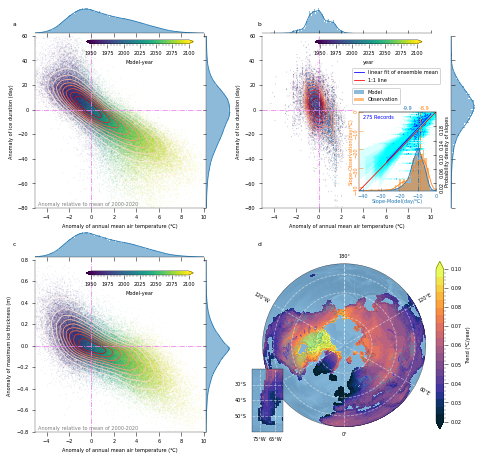

In [97]:
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize = (18 * cm,18.5 * cm))
plt.subplots_adjust(hspace=0.3, wspace = 0.35)
fig.text(0.08, 0.9, 'a', fontdict=dict(fontsize = 6))
fig.text(0.56, 0.9, 'b', fontdict=dict(fontsize = 6))
fig.text(0.08, 0.48, 'c', fontdict=dict(fontsize = 6))
fig.text(0.56, 0.48, 'd', fontdict=dict(fontsize = 6))

####################################################################################
ax1 = fig.add_subplot(2,2,1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1_x,ax1_y = hist_ax(ax = ax1, fig = fig, y_height=0.05)
#================================================================
sns.histplot(pl1_x, binwidth=0.1, kde = True, ax = ax1_x, element="step", edgecolor = None).lines[0].set_linewidth(0.8)
sns.histplot(y = pl1_y, binwidth = 1, kde = True, ax = ax1_y, element="step", edgecolor = None).lines[0].set_linewidth(0.8)
pl = ax1.scatter(pl1_x,
                 pl1_y,
                 c = pl1_c,
                 alpha = 0.15,
                 s = 0.8,
                 vmin = 1950,
                 vmax = 2100,
                 edgecolor = 'none')
sns.kdeplot(pl1_x,
            pl1_y,
            ax = ax1,
            linewidths = 0.8,
            cmap = 'Reds'
                    )

ax1.set_xlim(-5,10)
ax1.set_ylim(-80,60)
ax1.set_xlabel("Anomaly of annual mean air temperature (\u2103)")
ax1.set_ylabel("Anomaly of ice duration (day)")

ax1.axhline(0,
                      c = 'violet',
                     ls ='-.',
                     lw = 0.8)
ax1.axvline(0,
                      c = 'violet',
                     ls ='-.',
                     lw = 0.8)

ax1.text(-4.8,-78,'Anomaly relative to mean of 2000-2020',
                color = 'Gray',
                fontsize = 5)

cax1 = plt.axes([0.225,0.865,0.21,0.008])
cb1 = plt.colorbar(pl,
                   cax = cax1,
                  orientation = 'horizontal',
                  fraction = 0.05,
                  aspect = 40,
                  pad = 0.01,
                  extend = 'both')
cb1.set_label('Model-year')
cb1.minorticks_on()
cb1.ax.tick_params(labelsize = 5)
cb1.set_alpha(1)
cb1.draw_all()
####################################################################################
ax2 = fig.add_subplot(2,2,2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2_x,ax2_y = hist_ax(ax = ax2, fig = fig, y_height=0.05, yspacing = 0.04)
#================================================================
sns.histplot(tsa_ann_lake_anom_np, binwidth=0.1, kde = True, ax = ax2_x, element="step", edgecolor = None).lines[0].set_linewidth(0.8)
sns.histplot(y = lice_seq_anom_np, binwidth = 1, kde = True, ax = ax2_y, element="step", edgecolor = None).lines[0].set_linewidth(0.8)
pl = ax2.scatter(tsa_ann_lake_anom_np,
                         lice_seq_anom_np,
                         alpha = 0.4,
                         s = 0.8,
                         vmin = 1950,
                         vmax = 2100,
                         c = year_np,
                         cmap = 'viridis',
                edgecolor = 'none')
sns.kdeplot(tsa_ann_lake_anom_np,
            lice_seq_anom_np,
            ax = ax2,
            linewidths = 0.8,
            cmap = 'Reds'
                    )
ax2.axhline(0,
                    xmax = 0.55,
                    c = 'violet',
                    ls ='-.',
           lw = 0.8)
ax2.axvline(0,
                      c = 'violet',
                     ls ='-.',
           lw = 0.8)
ax2.set_xlim(-5,10)
ax2.set_ylim(-80, 60)
ax2.set_xlabel("Anomaly of annual mean air temperature (\u2103)")
ax2.set_ylabel("Anomaly of ice duration (day)")
ax2_y.tick_params(direction = 'in')
ax2_x.tick_params(direction = 'in')
## add color bar
cax2 = plt.axes([0.673,0.865,0.21,0.008])
cb2 = plt.colorbar(pl,
                   cax = cax2,
                  orientation = 'horizontal',
                  fraction = 0.05,
                  aspect = 40,
                  pad = 0.01,
                  extend = 'both')
cb2.set_label('year')
cb2.minorticks_on()
cb2.ax.tick_params(labelsize = 5)
cb2.set_alpha(1)
cb2.draw_all()
##

#================================================================
ax2_inax = plt.axes([0.76,0.585,0.15,0.15])
for i in np.arange(slope_mod.shape[1]):
    sns.regplot(x=slope_mod[:,i], 
                y=slope_obs,  
                color='b',
                scatter = True,
                scatter_kws={'color':'cyan',
                            's':0.8,
                            'alpha':0.2,
                            'edgecolor':'none'},
                line_kws={'alpha':0.1,'color':'cyan','linewidth':0.8},
                ax = ax2_inax
                    )
sns.regplot(x=slope_mod.mean(axis = 1), 
                 y=slope_obs,  
                 color='b',
                 scatter = True,
                 scatter_kws={'color':'Blue',
                              'marker':'D',
                              's':0.8,
                             'edgecolor':'none'},
                 robust=True,
                 ax = ax2_inax,
                 line_kws={'label':'linear fit of ensemble mean',
                           'color':'blue',
                          'linewidth':0.8},
                 )
ax2_inax.set_xlim((-42,0))
ax2_inax.set_ylim((-42,0))
ax2_inax.plot([-42,3],[-42,3],
        lw = 0.8,
        color = 'red',
        label = '1:1 line')
ax2_inax.legend(loc = [-0.1,1.35],
         fontsize = 5
         )
ax2_inax.set_xlabel('Slope-Model(day/\u2103)', 
              color = sns.color_palette()[0],
              labelpad = -0.05,
              fontsize = 5
             )
ax2_inax.tick_params(axis = 'x',
              colors = sns.color_palette()[0],
              direction = 'in',
              labelsize = 5)
ax2_inax.set_ylabel('Slope-Observation(day/\u2103)', 
              color = sns.color_palette()[1],
              labelpad = -0.05,
              fontsize = 5
             )
ax2_inax.tick_params(axis = 'y',
              colors = sns.color_palette()[1],
              direction = 'in',
              labelrotation = 90,
              labelsize = 5,
              pad = 1)

ax2_inax2 = ax2_inax.twinx()
sns.histplot(slope_mod[pvalue_obs < 0.1,:].flatten(), 
             label = 'Model',
             color = sns.color_palette()[0],
             stat = 'density',
             element = 'step',
             common_norm = True,
             edgecolor = None,
             bins = 50,
             kde = True,
             ax = ax2_inax2).lines[0].set_linewidth(0.8)
sns.histplot(slope_obs[pvalue_obs < 0.1], 
             label = 'Observation',
             bins = 40,
             color = sns.color_palette()[1],
             kde = True,
             stat = 'density',
             element = 'step',
             kde_kws=dict(cut = 2),
             edgecolor = None,
             ax = ax2_inax2).lines[1].set_linewidth(0.8)
ax2_inax2.axvline(x = np.mean(slope_mod), 
            color = sns.color_palette()[0],
            linestyle = '-.',
                 lw = 0.8)
ax2_inax2.axvline(x = slope_obs.mean(), 
            color = sns.color_palette()[1],
           linestyle = '-.',
                 lw = 0.8)
ax2_inax2.set_ylim((0,0.22))
ax2_inax2.spines['bottom'].set_color(sns.color_palette()[0])
ax2_inax2.spines['left'].set_color(sns.color_palette()[1])
ax2_inax2.set_ylabel('Probability density of slopes',
              labelpad = 1,
              fontsize = 5)
ax2_inax2.tick_params(axis = 'y',
              direction = 'in',
              labelrotation = 90,
              labelsize = 5)
ax2_inax2.yaxis.set_ticks(np.arange(0.02,0.22,0.04))
ax2_inax2.legend(loc = [-0.1,1.1],
         fontsize = 5,
          )
ax2_inax2.text(-18,0.225,
        '{0:.1f}'.format(np.mean(slope_mod)),
         color = sns.color_palette()[0],
        fontsize = 5)
ax2_inax2.text(-9,0.225,
        '{0:.1f}'.format(slope_obs.mean()),
         color = sns.color_palette()[1],
        fontsize = 5)
ax2_inax2.text(-40,0.2,
        str(slope_obs.shape[0]) + ' Records',
         color = 'blue',
        fontsize = 5)

####################################################################################
ax3 = fig.add_subplot(2,2,3)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3_x,ax3_y = hist_ax(ax = ax3, fig = fig, y_height=0.05)
#================================================================
sns.histplot(pl3_x, binwidth=0.1, kde = True, ax = ax3_x, element="step", edgecolor = None).lines[0].set_linewidth(0.8)
sns.histplot(y = pl3_y, binwidth = 0.01, kde = True, ax = ax3_y, element="step", edgecolor = None).lines[0].set_linewidth(0.8)
pl = ax3.scatter(pl3_x,
                 pl3_y,
                 c = pl1_c,
                 alpha = 0.15,
                 s = 0.8,
                 vmin = 1950,
                 vmax = 2100,
                 edgecolor = 'none')
sns.kdeplot(pl3_x,
            pl3_y,
            ax = ax3,
            linewidths = 0.8,
            cmap = 'Reds'
                    )

ax3.set_xlim(-5,10)
ax3.set_ylim(-0.8,0.8)
ax3.set_xlabel("Anomaly of annual mean air temperature (\u2103)")
ax3.set_ylabel("Anomaly of maximum ice thickness (m)")

ax3.axhline(0,
                      c = 'violet',
                     ls ='-.',
                     lw = 0.8)
ax3.axvline(0,
                      c = 'violet',
                     ls ='-.',
                     lw = 0.8)

ax3.text(-4.8,-0.78,'Anomaly relative to mean of 2000-2020',
                     color ='Gray',
                     fontsize = 5)
#
cax3 = plt.axes([0.225,0.424,0.21,0.008])
cb3 = plt.colorbar(pl,
                   cax = cax3,
                  orientation = 'horizontal',
                  fraction = 0.05,
                  aspect = 40,
                  pad = 0.01,
                  extend = 'both')
cb3.set_label('Model-year')
cb3.minorticks_on()
cb3.ax.tick_params(labelsize = 5)
cb3.set_alpha(1)
cb3.draw_all()
####################################################################################
## the data used in add_axes is get from "ax4.get_position().bounds"
ax4 = fig.add_axes([0.5702127659574467, 0.09, 0.4,0.4],
                   projection = ccrs.Orthographic(central_latitude=90) )
#================================================================
picolors = cmocean.cm.thermal(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(picolors) 


ax4.stock_img()
ax4.coastlines(linewidths = 0.1)
ax4.add_feature(cf.NaturalEarthFeature('physical', 'lakes', '110m'), 
                linewidths = 0.2,
               facecolor='None',
               edgecolor='Blue')

pl = tsa_trend2000_2100_ensmean.plot(vmin = 0.02, 
                                     vmax = 0.1, 
                                     ax = ax4,
                                     cmap = cmap,
                                     transform = ccrs.PlateCarree(),
                                     add_colorbar = False)
ax4.scatter(lon_1d_select,
            lat_1d_select,
            s = 0.8,
            edgecolor = 'none',
            c = 'C9',
            alpha = 0.5,
            transform = ccrs.PlateCarree())
ax4.gridlines(crs = ccrs.PlateCarree(),
              draw_labels = True,
              alpha = 0.5,
              color = 'w',
              linestyle='--',
              lw = 0.8,
              ylocs = (30,50,70))

cb = fig.colorbar(pl,
                 ax = ax4,
                 extend = 'both',
                 pad = 0.05,
                 shrink = 0.8)
cb.minorticks_on()
cb.set_label('Trend (\u2103/year)')

## insert southern Hemisphere 
ax4_inax = fig.add_axes([0.54,0.12499999999999989,0.08,0.12],
                 projection = ccrs.PlateCarree())
ax4_inax.stock_img()
ax4_inax.coastlines(linewidths = 0.1)
ax4_inax.set_extent([280,300,-60,-20])
tsa_trend2000_2100_ensmean.plot(vmin = 0.02, 
                                vmax = 0.1,
                                ax = ax4_inax,
                                cmap = cmap,
                                transform = ccrs.PlateCarree(),
                                add_colorbar = False)
ax4_inax.scatter(lon_1d_select,
            lat_1d_select,
            s = 0.8,
                 edgecolor = 'none',
            c = 'C9',
            alpha = 0.5,
            transform = ccrs.PlateCarree())
gl = ax4_inax.gridlines(crs = ccrs.PlateCarree(), 
                  draw_labels = True,
                  alpha = 0.5,
                  color = 'w',
                  linestyle='--',
                        lw=0.8,
                  ylocs = (-50,-40,-30),
                  xlocs = (-75,-65))
gl.top_labels = False
gl.right_labels = False
####################################################################################
plt.savefig('/proj/lhuang/scripts/CESM2-LENS/LAKE_ICE/Fig_2.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)